In [29]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [30]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import TSNE

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [31]:
berlin_wkdy = pd.read_csv("data/berlin_weekdays.csv")
list(berlin_wkdy.columns)

['Unnamed: 0',
 'realSum',
 'room_type',
 'room_shared',
 'room_private',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'metro_dist',
 'attr_index',
 'attr_index_norm',
 'rest_index',
 'rest_index_norm',
 'lng',
 'lat']

In [32]:
berlin_wknd = pd.read_csv("data/berlin_weekends.csv")
#list(berlin_wknd.columns)

In [33]:
#merging all the dataframes from kaggle into one large data frame 
countries = ['data/amsterdam', 'data/athens', 'data/barcelona', 'data/berlin', 
             'data/budapest', 'data/lisbon',  'data/london', 'data/paris', 'data/rome', 'data/vienna']

types = ['_weekdays.csv', '_weekends.csv']

country_dfs = []

for i in range(0, len(countries)):
    modified_dfs = []
    for j in range(0, 2):
        str = countries[i] + types[j]
        df = pd.read_csv(str)

        if types[j] == '_weekdays.csv':
            df["weekend"] = 0 
        else: 
            df["weekend"] = 1 

        modified_dfs.append(df)
        
    country_full_df = pd.concat(modified_dfs)
    country_full_df['country'] = countries[i][5:]
    country_dfs.append(country_full_df)

all_countries_df = pd.concat(country_dfs)

In [34]:
#scaling the numeric values in the dataframe 
numeric_preds = ['person_capacity', 'cleanliness_rating', 
                 'guest_satisfaction_overall', 
                'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 
                 'rest_index','rest_index_norm']

booleans_pred = ['Unnamed: 0', 'realSum', 'bedrooms', 'room_type', 'room_shared', 'room_private', 'host_is_superhost', 
                'multi', 'biz', 'weekend','country', 'lng', 'lat']
#subset for all categorial variables 
numeric_df = all_countries_df[numeric_preds]
scaler = StandardScaler()
scaled_numeric_df = scaler.fit_transform(numeric_df)
scaled_numeric_df = pd.DataFrame(scaled_numeric_df, columns=numeric_preds)
boolean_df = all_countries_df[booleans_pred]
scaled_numeric_df.reset_index(drop=True, inplace=True)
boolean_df.reset_index(drop=True, inplace=True)
scaled_all_countries = pd.concat([scaled_numeric_df, boolean_df], axis=1)
scaled_all_countries.shape

(51707, 22)

In [35]:
#turning categorial variables into multiple indicator variables

#scaled_all_countries['room_type'].unique()
#dummies = pd.get_dummies(scaled_all_countries.room_type)
 
#all_countries_df_final = pd.concat([scaled_all_countries, dummies], axis='columns')

#all_countries_df_final = merged.drop(['room_type'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['room_type'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['attr_index'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['attr_index_norm'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['rest_index_norm'], axis='columns')
scaled_all_countries.columns

Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'dist', 'metro_dist', 'rest_index', 'Unnamed: 0', 'realSum', 'bedrooms',
       'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz',
       'weekend', 'country', 'lng', 'lat'],
      dtype='object')

In [36]:
#calculating covariance 
#col_names = ['realSum', 'room_shared', 'room_private',
#       'person_capacity', 'host_is_superhost', 'multi', 'biz',
#       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
#       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
#       'rest_index_norm', 'lng', 'lat', 'weekend',
#       'Entire home/apt', 'Private room', 'Shared room']
col_names = ['realSum', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist','rest_index','lng', 'lat', 'weekend']
cov_dat = scaled_all_countries[col_names]
corr_matrix = cov_dat.corr()
all_countries_final = scaled_all_countries
all_countries_final.to_csv('countries_cleaned.csv', index=False)

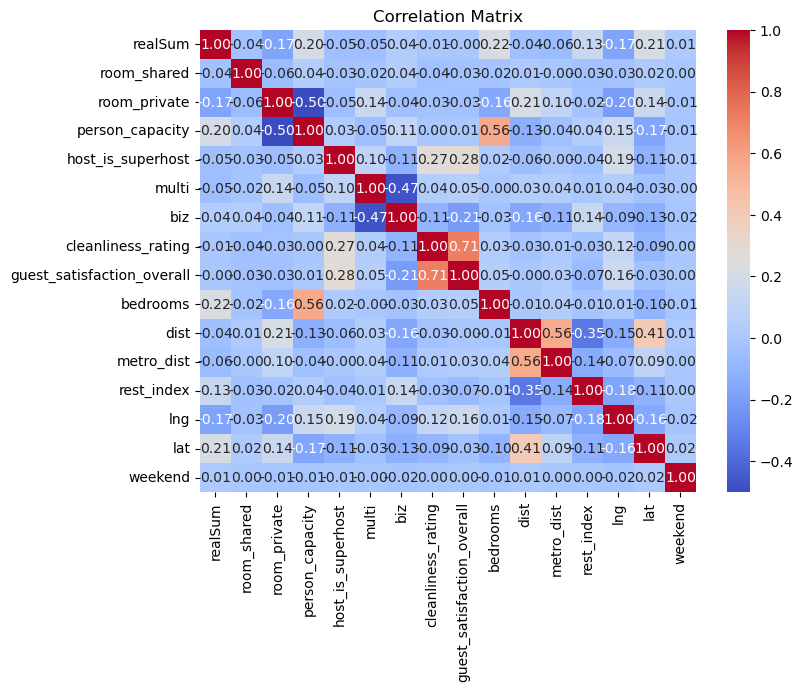

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300)  # DPI can be adjusted
plt.show()

In [38]:
#applying PCA to the data to visualize data 
country, X = all_countries_final['country'], all_countries_final.drop(columns='country').values
scaler = StandardScaler()
x_std = scaler.fit_transform(X)

pca = PCA(n_components = 2)

# Apply the PCA transformation 
X_transformed = pca.fit_transform(x_std)

# Get the explained variance ratios from the PCA
pca_scores = pca.explained_variance_ratio_

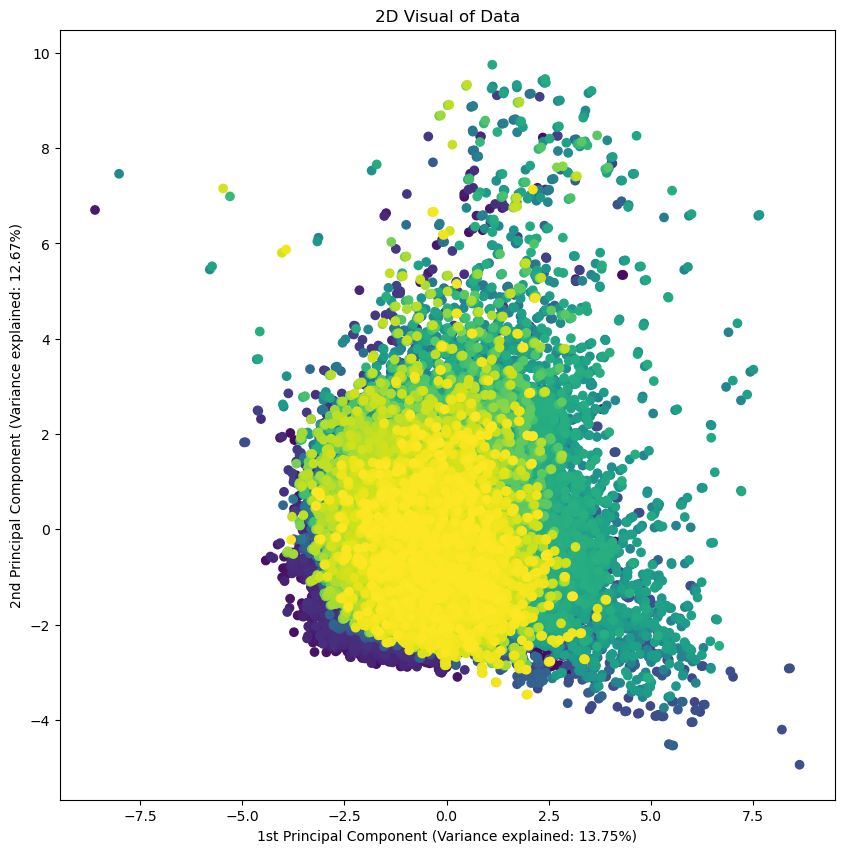

In [39]:
# Create a scatter plot
plt.figure(figsize=(10, 10))

unique_colors = np.arange(len(country))

scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=unique_colors, cmap='viridis')

# Label each point with the country name
#for i, country_name in enumerate(country):
#    plt.annotate(country_name, (X_transformed[i, 0], X_transformed[i, 1]))

# Set labels for the axes including variance explained
plt.xlabel(f'1st Principal Component (Variance explained: {pca_scores[0]*100:.2f}%)')
plt.ylabel(f'2nd Principal Component (Variance explained: {pca_scores[1]*100:.2f}%)')
plt.title('2D Visual of Data')

plt.show()

In [40]:
# # Assuming 'data' is your dataset (a pandas DataFrame)
# tsne = TSNE(n_components=2)  # n_components defines the output dimensions

# col_names = ['room_shared', 'room_private',
#        'person_capacity', 'host_is_superhost', 'multi', 'biz',
#        'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
#        'metro_dist','rest_index','lng', 'lat', 'weekend']

# X_dat = all_countries_final[col_names]

# # Fit and transform the data
# tsne_result = tsne.fit_transform(X_dat)

# # Converting the result into a DataFrame
# tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

In [41]:
# tsne_df['color'] = all_countries_final['weekend']
# tsne_df['country'] = all_countries_final['country']
# tsne_df.shape

In [42]:
# #plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'])
# sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='color', data=tsne_df)
# plt.title('t-SNE Visualization against weekend')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.show()

In [43]:
# #plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'])
# sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='country', data=tsne_df)
# plt.title('t-SNE Visualization against country')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [44]:
airbnbData = pd.read_csv("countries_cleaned_new.csv")
airbnbData.head()
# airbnbData.shape
# airbnbData.dtypes

,person_capacity,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,rest_index,Unnamed: 0,realSum,bedrooms,room_shared,room_private,host_is_superhost,multi,biz,weekend,country,lng,lat
0,-0.895,0.638,0.042,0.765,2.165,-1.062,0,194.034,1,False,True,False,1,0,0,amsterdam,4.906,52.418
1,0.646,-1.456,-0.853,-1.129,-0.515,0.423,1,344.246,1,False,True,False,0,0,0,amsterdam,4.900,52.374
2,-0.895,-0.409,-0.629,1.068,3.462,-1.067,2,264.101,1,False,True,False,0,1,0,amsterdam,4.975,52.361
3,0.646,-0.409,-0.294,-1.172,-0.282,0.498,3,433.529,2,False,True,False,0,1,0,amsterdam,4.894,52.377
4,-0.895,0.638,0.601,-1.106,-0.423,0.378,4,485.553,1,False,True,True,0,0,0,amsterdam,4.901,52.375


In [45]:
# Visualize the predictors
predictors_to_visualize = ["person_capacity", "cleanliness_rating", 
                           "guest_satisfaction_overall", "bedrooms", 
                           "dist", "metro_dist", "rest_index", "room_shared", "room_private", 
                            "host_is_superhost", "multi", "biz", "weekend", "country", "lng", "lat"]

continuous_predictors = ["person_capacity", "cleanliness_rating", "guest_satisfaction_overall", 
                        "dist", "metro_dist", "rest_index", "lng", "lat"]
continuous_predictors_names = ["Person Capacity", "Cleanliness Rating", "Guest Satisfaction Overall", 
                             "Distance from City Centre", "Distance from Nearest Metro Station",
                                "Restaurant Index", "Longitude", "Latitude"]

binary_predictors = ["room_shared", "room_private", "host_is_superhost", "multi", "biz", "weekend"]
binary_predictors_names = ["Shared Room (1 = true, 0 = otherwise)", "Private Room (1 = true, 0 = otherwise)", 
                           "Host is Superhost (1 = true, 0 = otherwise)", "Listing has multiple rooms (1 = true, 0 = otherwise)", 
                           "Listing is for business purposes (1 = true, 0 = otherwise)", "Weekend Price (1 = true, 0 = otherwise)"]

categorical_nonbinary_predictors = ["bedrooms"]
categorical_nonbinary_predictors_names = ["Number of Bedrooms"]

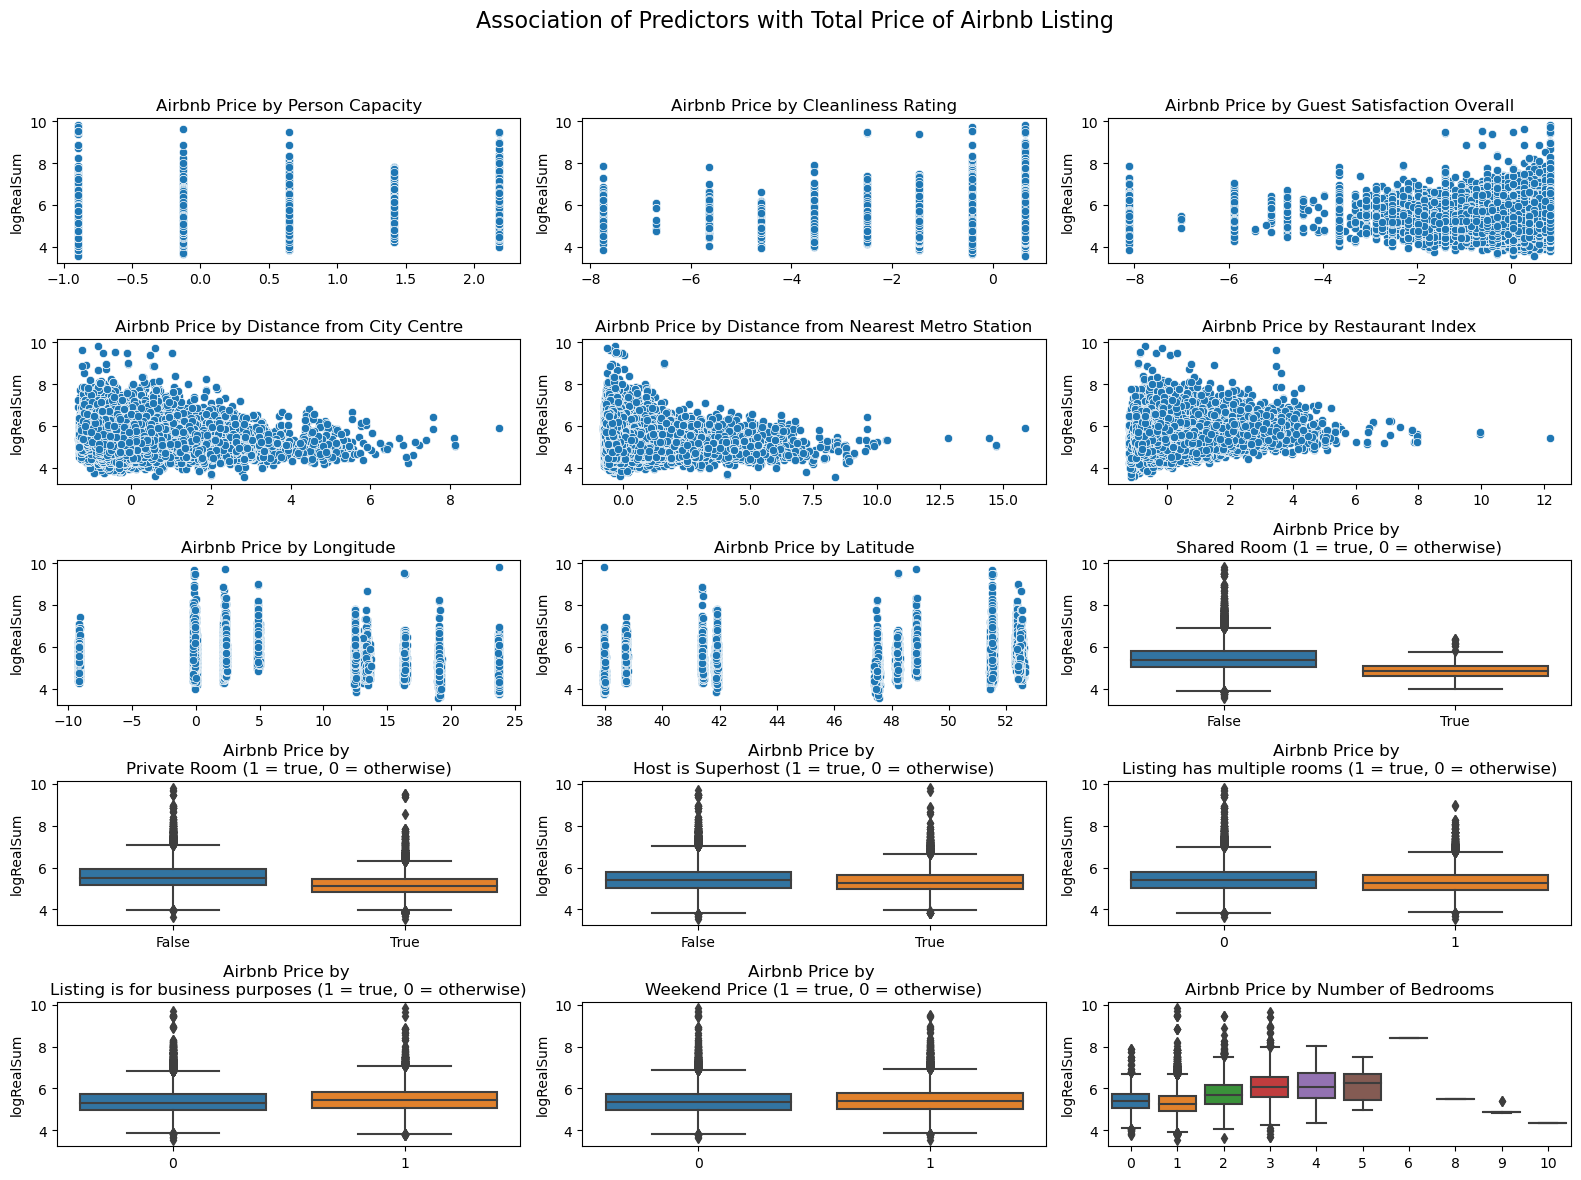

In [46]:
import warnings
warnings.filterwarnings("ignore")

# Convert realSum to log value
airbnbData["logRealSum"] = np.log(airbnbData["realSum"])

# Create a 3x4 grid of subplots for visualizing predictors
fig, axes = plt.subplots(5, 3, figsize=(16, 12))
fig.suptitle("Association of Predictors with Total Price of Airbnb Listing", fontsize=16)
plt.subplots_adjust(hspace=0.5, wspace=0.8)

for i, (predictor, name) in enumerate(zip(continuous_predictors, continuous_predictors_names)):
    row, col = divmod(i, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Select the current subplot

    # Create histograms for the continuous predictors (admitted as hue)
    sns.scatterplot(data=airbnbData, x=predictor, y="logRealSum", ax=ax)
    ax.set_title(f"Airbnb Price by {name}", fontsize=12)
    ax.set_xlabel("")  # Remove x-axis label for clarity

for i, (predictor, name) in enumerate(zip(binary_predictors, binary_predictors_names)):
    row, col = divmod(i+8, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Select the current subplot

    # Create barplots for the binary predictora based on admission 
    sns.boxplot(data=airbnbData, x=predictor, y="logRealSum", ax=ax)
    ax.set_title(f"Airbnb Price by \n{name}", fontsize=12)
    ax.set_xlabel("")  # Remove x-axis label for clarity


for i, (predictor, name) in enumerate(zip(categorical_nonbinary_predictors, categorical_nonbinary_predictors_names)):
    row, col = divmod(i+14, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Select the current subplot

    # Create histograms for the categorical non-binary predictors (admitted as hue)
    sns.boxplot(data=airbnbData, x=predictor, y="logRealSum", ax=ax)
    ax.set_title(f"Airbnb Price by {name}", fontsize=12)
    ax.set_xlabel("")  # Remove x-axis label for clarity

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot layout and title position
plt.show()


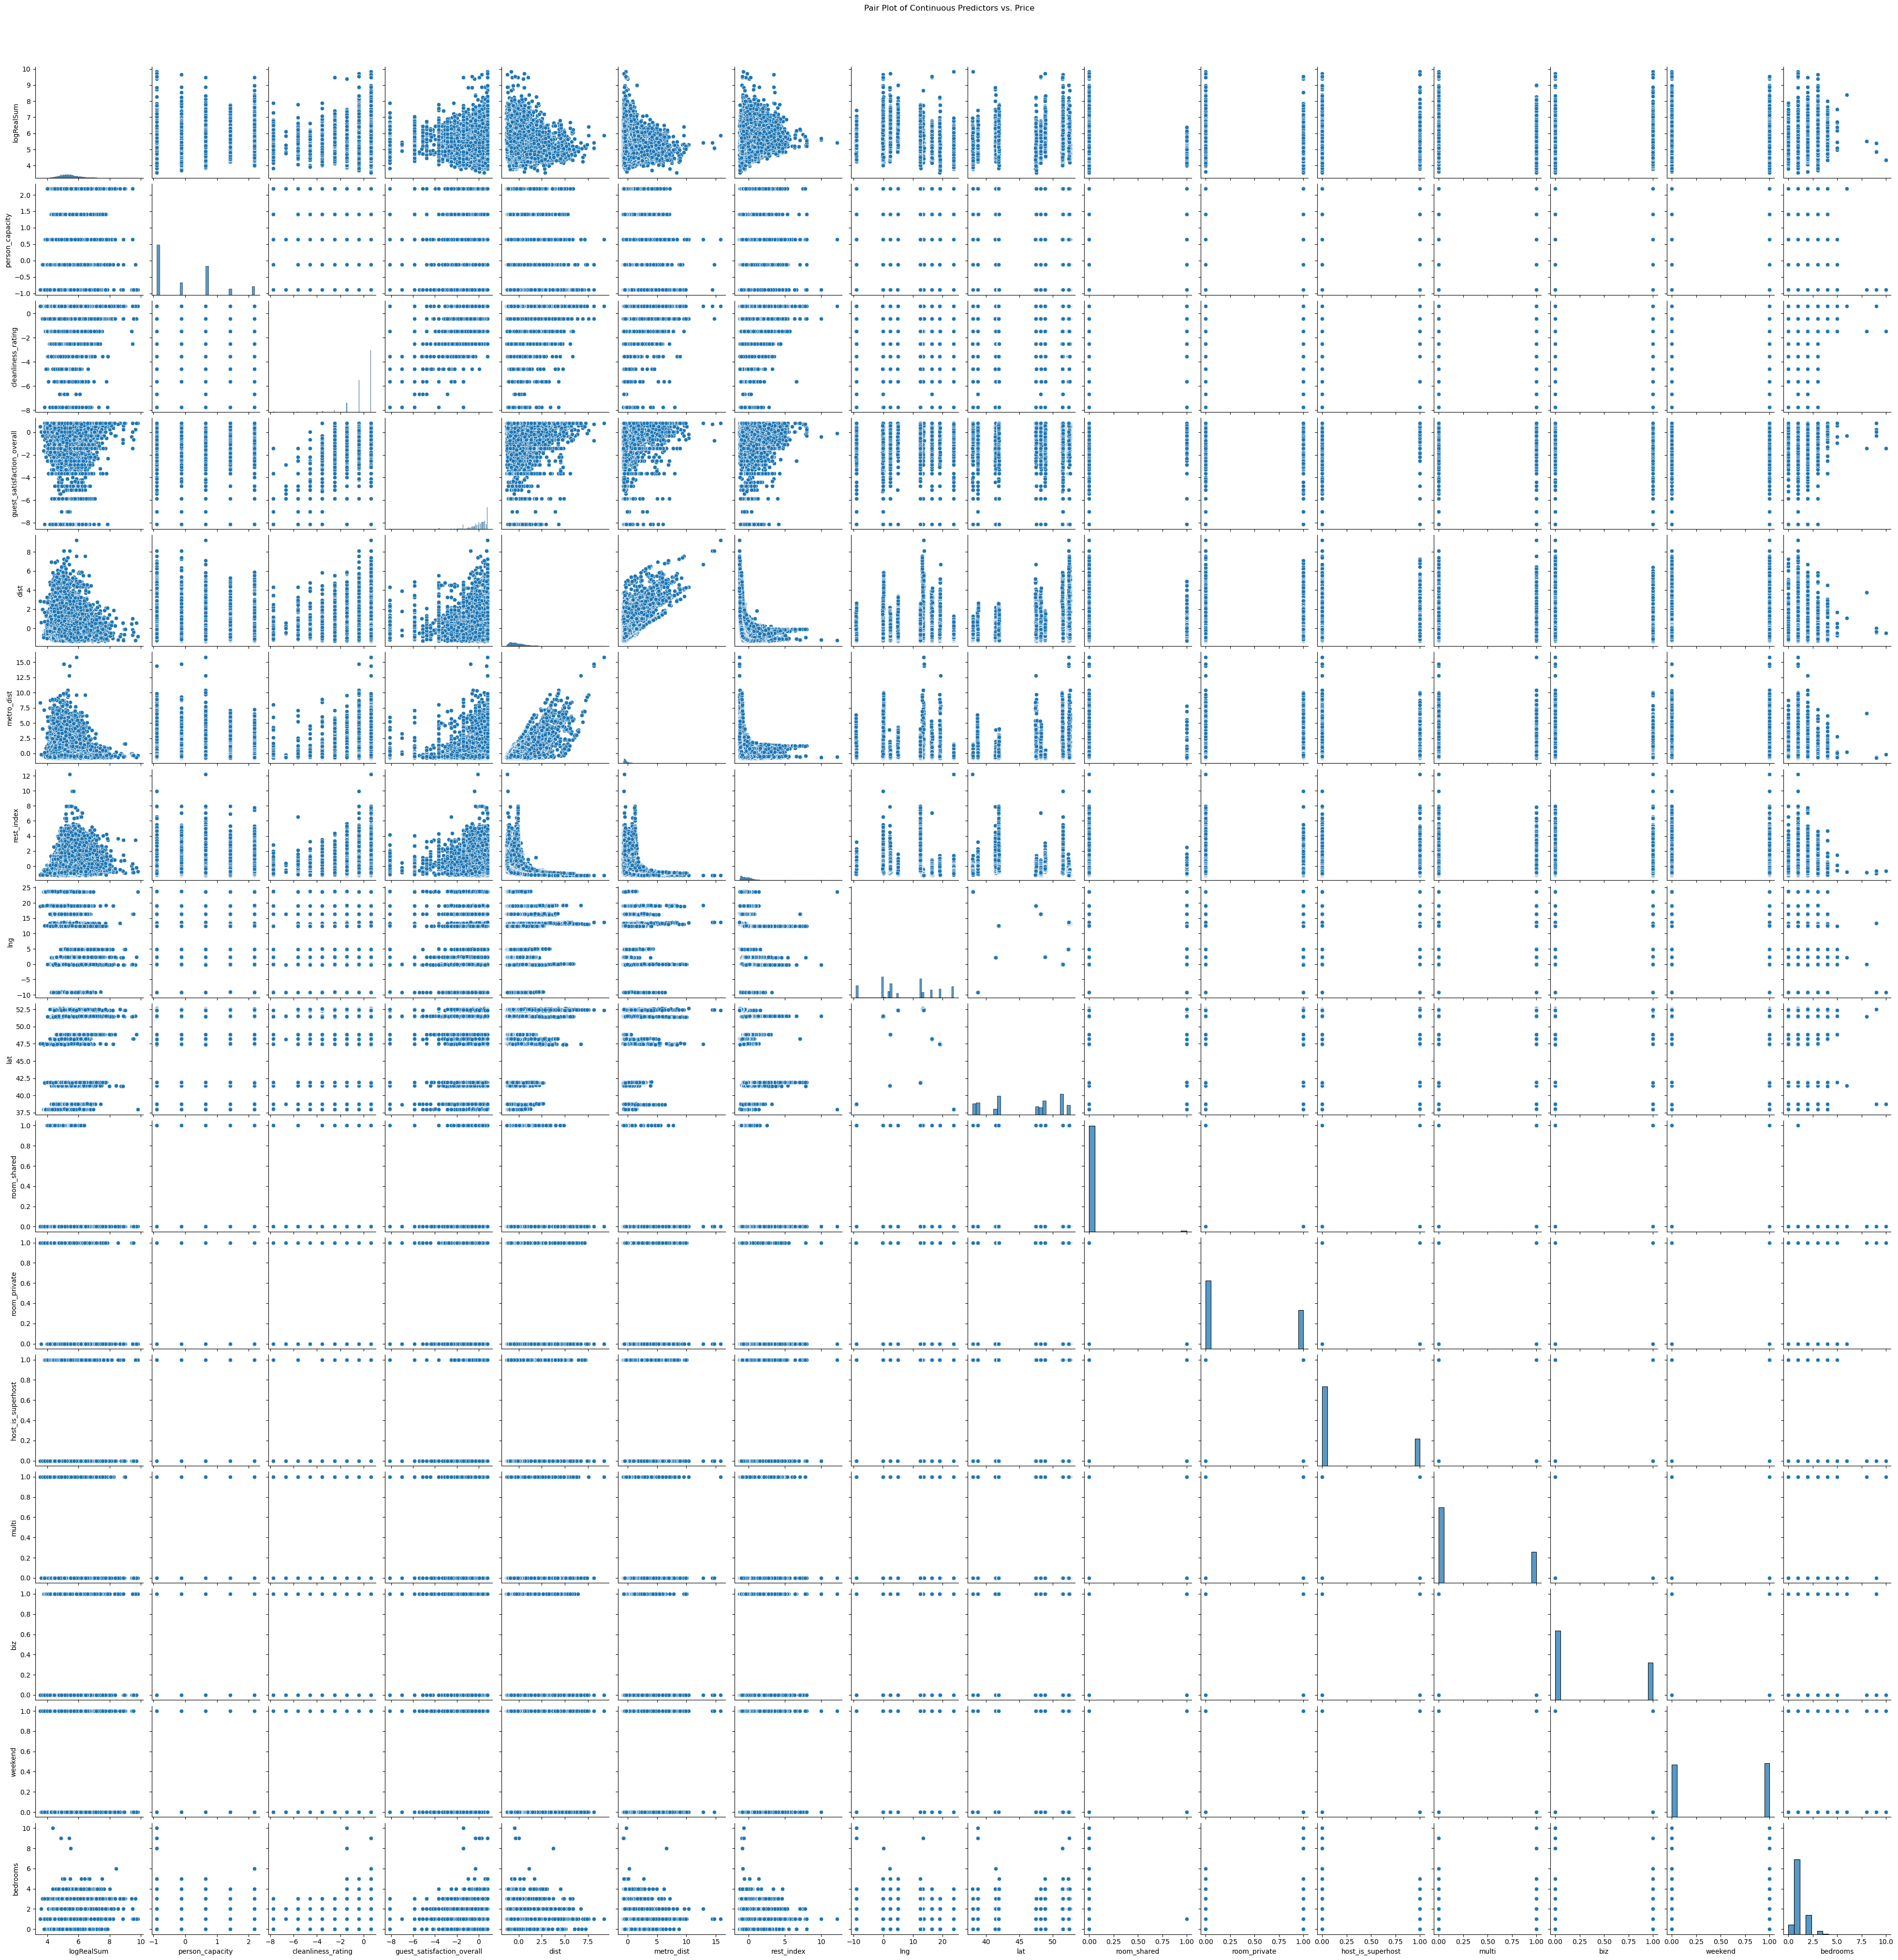

In [48]:
pair_plot_data = airbnbData[["logRealSum", "person_capacity", "cleanliness_rating", "guest_satisfaction_overall",
                              "dist", "metro_dist", "rest_index", "lng", "lat", "room_shared", "room_private",
                              "host_is_superhost", "multi", "biz", "weekend", "bedrooms"]]

# Create pair plot
sns.pairplot(pair_plot_data, markers=["o", "s"], palette="husl")
plt.suptitle("Pair Plot of Continuous Predictors vs. Price", y=1.02)
plt.show()